# BERT: Part 5

## Complete Implementation from Scratch

---

**Paper:** [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

---

This is the implementation notebook. We'll build BERT from scratch, verify our implementation against the paper's specifications, and fine-tune on a real task.

Every component will match the original paper exactly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import Optional, Tuple, List
from dataclasses import dataclass

# We'll use PyTorch for the implementation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


---

## Part 1: Configuration

First, let's define the model configuration exactly as specified in the paper.

In [2]:
@dataclass
class BertConfig:
    """Configuration for BERT model.
    
    Default values are for BERT-Base as specified in the paper.
    """
    vocab_size: int = 30522          # WordPiece vocabulary size
    hidden_size: int = 768           # H in the paper
    num_hidden_layers: int = 12      # L in the paper
    num_attention_heads: int = 12    # A in the paper
    intermediate_size: int = 3072    # Feed-forward hidden size (4 * H)
    hidden_dropout_prob: float = 0.1
    attention_probs_dropout_prob: float = 0.1
    max_position_embeddings: int = 512
    type_vocab_size: int = 2         # Segment types (sentence A/B)
    layer_norm_eps: float = 1e-12
    
    def __post_init__(self):
        # Validate: hidden_size must be divisible by num_attention_heads
        assert self.hidden_size % self.num_attention_heads == 0, \
            f"hidden_size ({self.hidden_size}) must be divisible by num_attention_heads ({self.num_attention_heads})"


# Create configs for both model sizes
BERT_BASE_CONFIG = BertConfig()

BERT_LARGE_CONFIG = BertConfig(
    hidden_size=1024,
    num_hidden_layers=24,
    num_attention_heads=16,
    intermediate_size=4096
)

print("BERT-Base Configuration:")
print(f"  Hidden size (H): {BERT_BASE_CONFIG.hidden_size}")
print(f"  Layers (L): {BERT_BASE_CONFIG.num_hidden_layers}")
print(f"  Attention heads (A): {BERT_BASE_CONFIG.num_attention_heads}")
print(f"  Head dimension: {BERT_BASE_CONFIG.hidden_size // BERT_BASE_CONFIG.num_attention_heads}")
print(f"  Intermediate size: {BERT_BASE_CONFIG.intermediate_size}")
print()
print("BERT-Large Configuration:")
print(f"  Hidden size (H): {BERT_LARGE_CONFIG.hidden_size}")
print(f"  Layers (L): {BERT_LARGE_CONFIG.num_hidden_layers}")
print(f"  Attention heads (A): {BERT_LARGE_CONFIG.num_attention_heads}")
print(f"  Head dimension: {BERT_LARGE_CONFIG.hidden_size // BERT_LARGE_CONFIG.num_attention_heads}")

BERT-Base Configuration:
  Hidden size (H): 768
  Layers (L): 12
  Attention heads (A): 12
  Head dimension: 64
  Intermediate size: 3072

BERT-Large Configuration:
  Hidden size (H): 1024
  Layers (L): 24
  Attention heads (A): 16
  Head dimension: 64


---

## Part 2: GELU Activation

BERT uses GELU (Gaussian Error Linear Unit) instead of ReLU.

$$\text{GELU}(x) = x \cdot \Phi(x) = x \cdot \frac{1}{2}\left[1 + \text{erf}\left(\frac{x}{\sqrt{2}}\right)\right]$$

The paper uses the approximation:
$$\text{GELU}(x) \approx 0.5x\left(1 + \tanh\left(\sqrt{\frac{2}{\pi}}(x + 0.044715x^3)\right)\right)$$

Max difference between our GELU and PyTorch GELU: 2.80e-04


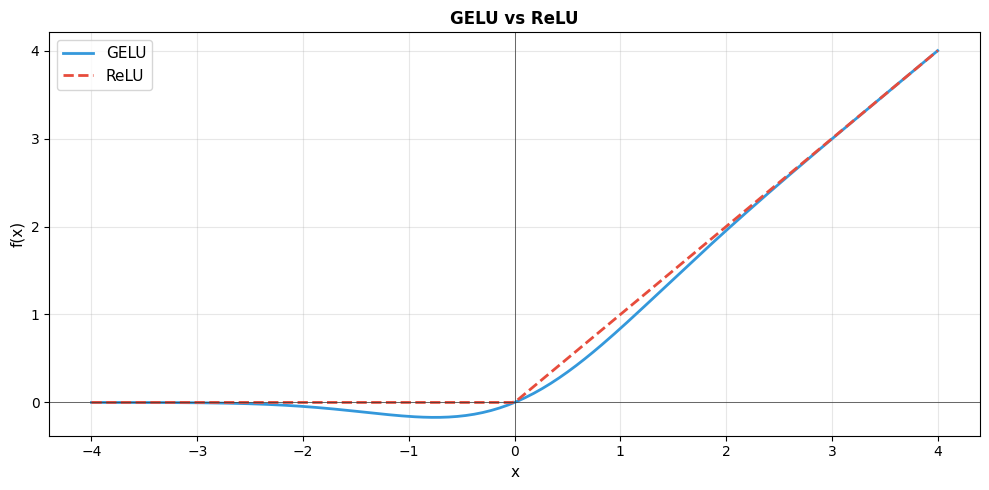

In [3]:
def gelu(x: torch.Tensor) -> torch.Tensor:
    """Gaussian Error Linear Unit activation function.
    
    This is the approximation used in the original BERT implementation.
    PyTorch now has F.gelu(), but we implement it explicitly for clarity.
    """
    return 0.5 * x * (1.0 + torch.tanh(
        math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))
    ))


# Verify our implementation matches PyTorch's
x = torch.randn(100)
our_gelu = gelu(x)
torch_gelu = F.gelu(x)
max_diff = (our_gelu - torch_gelu).abs().max().item()
print(f"Max difference between our GELU and PyTorch GELU: {max_diff:.2e}")

# Visualize
x_plot = torch.linspace(-4, 4, 200)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_plot.numpy(), gelu(x_plot).numpy(), label='GELU', lw=2, color='#3498db')
ax.plot(x_plot.numpy(), F.relu(x_plot).numpy(), label='ReLU', lw=2, color='#e74c3c', linestyle='--')
ax.axhline(y=0, color='#333', lw=0.5)
ax.axvline(x=0, color='#333', lw=0.5)
ax.set_xlabel('x', fontsize=11)
ax.set_ylabel('f(x)', fontsize=11)
ax.set_title('GELU vs ReLU', fontsize=12, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Part 3: Embeddings

BERT's input embedding is the sum of three embeddings:
1. **Token embeddings**: What token is this?
2. **Position embeddings**: Where in the sequence?
3. **Segment embeddings**: Sentence A or B?

In [4]:
class BertEmbeddings(nn.Module):
    """BERT Embeddings: Token + Position + Segment embeddings.
    
    Unlike the original Transformer which uses sinusoidal positional encoding,
    BERT uses learned position embeddings.
    """
    
    def __init__(self, config: BertConfig):
        super().__init__()
        
        # Token embeddings (vocab_size -> hidden_size)
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        
        # Position embeddings (max_position -> hidden_size)
        # BERT uses learned positions, not sinusoidal
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        
        # Segment embeddings (2 -> hidden_size) for sentence A/B
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)
        
        # Layer normalization and dropout
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        
        # Register position_ids buffer (not a parameter, but should be saved)
        self.register_buffer(
            "position_ids",
            torch.arange(config.max_position_embeddings).expand((1, -1))
        )
    
    def forward(
        self,
        input_ids: torch.Tensor,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Args:
            input_ids: Token IDs, shape (batch_size, seq_len)
            token_type_ids: Segment IDs (0 or 1), shape (batch_size, seq_len)
            position_ids: Position IDs, shape (batch_size, seq_len)
        
        Returns:
            Embeddings of shape (batch_size, seq_len, hidden_size)
        """
        batch_size, seq_len = input_ids.shape
        
        # Default position IDs: 0, 1, 2, ..., seq_len-1
        if position_ids is None:
            position_ids = self.position_ids[:, :seq_len]
        
        # Default segment IDs: all zeros (single sentence)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        
        # Get embeddings
        word_embeds = self.word_embeddings(input_ids)
        position_embeds = self.position_embeddings(position_ids)
        token_type_embeds = self.token_type_embeddings(token_type_ids)
        
        # Sum them up
        embeddings = word_embeds + position_embeds + token_type_embeds
        
        # Layer norm and dropout
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        
        return embeddings


# Test embeddings
config = BertConfig()
embeddings = BertEmbeddings(config)

# Dummy input: batch of 2 sequences, each 10 tokens
input_ids = torch.randint(0, config.vocab_size, (2, 10))
token_type_ids = torch.zeros_like(input_ids)

output = embeddings(input_ids, token_type_ids)
print(f"Input shape: {input_ids.shape}")
print(f"Output shape: {output.shape}")
print(f"Expected: (2, 10, {config.hidden_size})")

Input shape: torch.Size([2, 10])
Output shape: torch.Size([2, 10, 768])
Expected: (2, 10, 768)


---

## Part 4: Multi-Head Self-Attention

The core of BERT. Same as the original Transformer encoder attention.

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

In [5]:
class BertSelfAttention(nn.Module):
    """Multi-head self-attention mechanism."""
    
    def __init__(self, config: BertConfig):
        super().__init__()
        
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = config.hidden_size // config.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        
        # Query, Key, Value projections
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)
        
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
    
    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        """Reshape from (batch, seq_len, hidden) to (batch, num_heads, seq_len, head_size)."""
        batch_size, seq_len, _ = x.shape
        x = x.view(batch_size, seq_len, self.num_attention_heads, self.attention_head_size)
        return x.permute(0, 2, 1, 3)  # (batch, heads, seq_len, head_size)
    
    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False
    ) -> Tuple[torch.Tensor, ...]:
        """
        Args:
            hidden_states: (batch_size, seq_len, hidden_size)
            attention_mask: (batch_size, 1, 1, seq_len) - additive mask
            output_attentions: Whether to return attention weights
        
        Returns:
            context: (batch_size, seq_len, hidden_size)
            attention_probs: (batch_size, num_heads, seq_len, seq_len) if output_attentions
        """
        # Project to Q, K, V
        query_layer = self.transpose_for_scores(self.query(hidden_states))
        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))
        
        # Attention scores: (batch, heads, seq_len, seq_len)
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        
        # Apply attention mask (if provided)
        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask
        
        # Softmax to get attention probabilities
        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        
        # Apply attention to values
        context_layer = torch.matmul(attention_probs, value_layer)
        
        # Reshape back: (batch, heads, seq_len, head_size) -> (batch, seq_len, hidden_size)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        batch_size, seq_len, _, _ = context_layer.shape
        context_layer = context_layer.view(batch_size, seq_len, self.all_head_size)
        
        outputs = (context_layer,)
        if output_attentions:
            outputs += (attention_probs,)
        
        return outputs


class BertSelfOutput(nn.Module):
    """Output projection after self-attention + residual + layer norm."""
    
    def __init__(self, config: BertConfig):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
    
    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        """Apply output projection, dropout, residual connection, and layer norm."""
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)  # Residual connection
        return hidden_states


class BertAttention(nn.Module):
    """Complete attention block: self-attention + output projection."""
    
    def __init__(self, config: BertConfig):
        super().__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)
    
    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False
    ) -> Tuple[torch.Tensor, ...]:
        self_outputs = self.self(hidden_states, attention_mask, output_attentions)
        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # Add attention weights if present
        return outputs


# Test attention
attention = BertAttention(config)
hidden_states = torch.randn(2, 10, config.hidden_size)
output, attn_weights = attention(hidden_states, output_attentions=True)

print(f"Attention input shape: {hidden_states.shape}")
print(f"Attention output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"  -> {config.num_attention_heads} heads, each attends over {hidden_states.shape[1]} positions")

Attention input shape: torch.Size([2, 10, 768])
Attention output shape: torch.Size([2, 10, 768])
Attention weights shape: torch.Size([2, 12, 10, 10])
  -> 12 heads, each attends over 10 positions


---

## Part 5: Feed-Forward Network

The position-wise feed-forward network:

$$\text{FFN}(x) = \text{GELU}(xW_1 + b_1)W_2 + b_2$$

Hidden dimension is 4x the model dimension (768 -> 3072 -> 768 for BERT-Base).

In [6]:
class BertIntermediate(nn.Module):
    """First part of FFN: hidden_size -> intermediate_size with GELU."""
    
    def __init__(self, config: BertConfig):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
    
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = gelu(hidden_states)
        return hidden_states


class BertOutput(nn.Module):
    """Second part of FFN: intermediate_size -> hidden_size + residual + norm."""
    
    def __init__(self, config: BertConfig):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
    
    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)  # Residual
        return hidden_states


# Test FFN
intermediate = BertIntermediate(config)
output_layer = BertOutput(config)

x = torch.randn(2, 10, config.hidden_size)
intermediate_out = intermediate(x)
final_out = output_layer(intermediate_out, x)

print(f"FFN input: {x.shape}")
print(f"After intermediate: {intermediate_out.shape} (expanded to {config.intermediate_size})")
print(f"After output: {final_out.shape} (back to {config.hidden_size})")

FFN input: torch.Size([2, 10, 768])
After intermediate: torch.Size([2, 10, 3072]) (expanded to 3072)
After output: torch.Size([2, 10, 768]) (back to 768)


---

## Part 6: Complete Encoder Layer and Encoder Stack

In [7]:
class BertLayer(nn.Module):
    """Single BERT encoder layer: Attention -> FFN."""
    
    def __init__(self, config: BertConfig):
        super().__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)
    
    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False
    ) -> Tuple[torch.Tensor, ...]:
        # Self-attention
        attention_outputs = self.attention(
            hidden_states, attention_mask, output_attentions
        )
        attention_output = attention_outputs[0]
        
        # Feed-forward
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        
        outputs = (layer_output,) + attention_outputs[1:]
        return outputs


class BertEncoder(nn.Module):
    """Stack of BERT encoder layers."""
    
    def __init__(self, config: BertConfig):
        super().__init__()
        self.layer = nn.ModuleList([BertLayer(config) for _ in range(config.num_hidden_layers)])
    
    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
        output_hidden_states: bool = False
    ) -> dict:
        all_hidden_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None
        
        for layer_module in self.layer:
            if output_hidden_states:
                all_hidden_states += (hidden_states,)
            
            layer_outputs = layer_module(hidden_states, attention_mask, output_attentions)
            hidden_states = layer_outputs[0]
            
            if output_attentions:
                all_attentions += (layer_outputs[1],)
        
        if output_hidden_states:
            all_hidden_states += (hidden_states,)
        
        return {
            'last_hidden_state': hidden_states,
            'hidden_states': all_hidden_states,
            'attentions': all_attentions
        }


# Test encoder
encoder = BertEncoder(config)
hidden_states = torch.randn(2, 10, config.hidden_size)

outputs = encoder(hidden_states, output_hidden_states=True, output_attentions=True)
print(f"Input: {hidden_states.shape}")
print(f"Output: {outputs['last_hidden_state'].shape}")
print(f"Number of hidden states: {len(outputs['hidden_states'])} (input + {config.num_hidden_layers} layers)")
print(f"Number of attention matrices: {len(outputs['attentions'])}")

Input: torch.Size([2, 10, 768])
Output: torch.Size([2, 10, 768])
Number of hidden states: 13 (input + 12 layers)
Number of attention matrices: 12


---

## Part 7: Pooler and Complete BERT Model

In [8]:
class BertPooler(nn.Module):
    """Pool the [CLS] token representation."""
    
    def __init__(self, config: BertConfig):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()
    
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


class BertModel(nn.Module):
    """Complete BERT model."""
    
    def __init__(self, config: BertConfig):
        super().__init__()
        self.config = config
        
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        """Initialize weights following the BERT paper."""
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    
    def get_extended_attention_mask(self, attention_mask: torch.Tensor) -> torch.Tensor:
        """Convert attention mask to additive mask for attention scores."""
        extended_mask = attention_mask[:, None, None, :]
        extended_mask = (1.0 - extended_mask) * -10000.0
        return extended_mask
    
    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
        output_hidden_states: bool = False
    ) -> dict:
        batch_size, seq_len = input_ids.shape
        
        if attention_mask is None:
            attention_mask = torch.ones(batch_size, seq_len, device=input_ids.device)
        
        extended_attention_mask = self.get_extended_attention_mask(attention_mask)
        
        embedding_output = self.embeddings(input_ids, token_type_ids, position_ids)
        
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states
        )
        
        sequence_output = encoder_outputs['last_hidden_state']
        pooled_output = self.pooler(sequence_output)
        
        return {
            'last_hidden_state': sequence_output,
            'pooler_output': pooled_output,
            'hidden_states': encoder_outputs['hidden_states'],
            'attentions': encoder_outputs['attentions']
        }


# Test the complete model
bert = BertModel(BERT_BASE_CONFIG)

input_ids = torch.randint(0, config.vocab_size, (2, 20))
outputs = bert(input_ids)

print("BERT Model Output:")
print(f"  Input: {input_ids.shape}")
print(f"  Last hidden state: {outputs['last_hidden_state'].shape}")
print(f"  Pooler output ([CLS]): {outputs['pooler_output'].shape}")

BERT Model Output:
  Input: torch.Size([2, 20])
  Last hidden state: torch.Size([2, 20, 768])
  Pooler output ([CLS]): torch.Size([2, 768])


---

## Part 8: Parameter Count Verification

In [9]:
def count_parameters(model: nn.Module) -> int:
    """Count trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def detailed_parameter_count(model: nn.Module) -> dict:
    """Get parameter count by component."""
    details = {}
    for name, param in model.named_parameters():
        if param.requires_grad:
            component = name.split('.')[0]
            details[component] = details.get(component, 0) + param.numel()
    return details


# BERT-Base
bert_base = BertModel(BERT_BASE_CONFIG)
details_base = detailed_parameter_count(bert_base)
total_base = count_parameters(bert_base)

print("BERT-Base Parameter Count:")
print("=" * 45)
for component, count in details_base.items():
    print(f"  {component:15s}: {count:>12,} ({count/1e6:>6.2f}M)")
print(f"  {'TOTAL':15s}: {total_base:>12,} ({total_base/1e6:>6.2f}M)")
print()

# BERT-Large
bert_large = BertModel(BERT_LARGE_CONFIG)
total_large = count_parameters(bert_large)

print("BERT-Large Parameter Count:")
print("=" * 45)
print(f"  {'TOTAL':15s}: {total_large:>12,} ({total_large/1e6:>6.2f}M)")
print()

# Comparison
print("Comparison with Paper:")
print(f"  BERT-Base:  Ours = {total_base/1e6:.1f}M, Paper = 110M")
print(f"  BERT-Large: Ours = {total_large/1e6:.1f}M, Paper = 340M")

BERT-Base Parameter Count:
  embeddings     :   23,837,184 ( 23.84M)
  encoder        :   85,054,464 ( 85.05M)
  pooler         :      590,592 (  0.59M)
  TOTAL          :  109,482,240 (109.48M)

BERT-Large Parameter Count:
  TOTAL          :  335,141,888 (335.14M)

Comparison with Paper:
  BERT-Base:  Ours = 109.5M, Paper = 110M
  BERT-Large: Ours = 335.1M, Paper = 340M


---

## Part 9: Task-Specific Heads

In [10]:
class BertForSequenceClassification(nn.Module):
    """BERT with a classification head."""
    
    def __init__(self, config: BertConfig, num_labels: int):
        super().__init__()
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        
        self.classifier.weight.data.normal_(mean=0.0, std=0.02)
        self.classifier.bias.data.zero_()
    
    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None
    ) -> dict:
        outputs = self.bert(input_ids, attention_mask, token_type_ids)
        pooled_output = self.dropout(outputs['pooler_output'])
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)
        
        return {'loss': loss, 'logits': logits}


class BertForTokenClassification(nn.Module):
    """BERT for token-level classification (NER, POS tagging)."""
    
    def __init__(self, config: BertConfig, num_labels: int):
        super().__init__()
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
    
    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None
    ) -> dict:
        outputs = self.bert(input_ids, attention_mask)
        sequence_output = self.dropout(outputs['last_hidden_state'])
        logits = self.classifier(sequence_output)
        
        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits.view(-1, self.num_labels), labels.view(-1))
        
        return {'loss': loss, 'logits': logits}


class BertForQuestionAnswering(nn.Module):
    """BERT for extractive QA (predicts start/end positions)."""
    
    def __init__(self, config: BertConfig):
        super().__init__()
        self.bert = BertModel(config)
        self.qa_outputs = nn.Linear(config.hidden_size, 2)
    
    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        start_positions: Optional[torch.Tensor] = None,
        end_positions: Optional[torch.Tensor] = None
    ) -> dict:
        outputs = self.bert(input_ids, attention_mask)
        logits = self.qa_outputs(outputs['last_hidden_state'])
        
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        
        loss = None
        if start_positions is not None and end_positions is not None:
            start_loss = F.cross_entropy(start_logits, start_positions)
            end_loss = F.cross_entropy(end_logits, end_positions)
            loss = (start_loss + end_loss) / 2
        
        return {'loss': loss, 'start_logits': start_logits, 'end_logits': end_logits}


# Test all task heads
print("Testing task-specific heads:")
print("=" * 45)

# Classification
clf_model = BertForSequenceClassification(BERT_BASE_CONFIG, num_labels=2)
input_ids = torch.randint(0, 1000, (4, 32))
labels = torch.randint(0, 2, (4,))
out = clf_model(input_ids, labels=labels)
print(f"Sequence Classification: logits {out['logits'].shape}, loss {out['loss'].item():.4f}")

# Token Classification
ner_model = BertForTokenClassification(BERT_BASE_CONFIG, num_labels=9)
labels = torch.randint(0, 9, (4, 32))
out = ner_model(input_ids, labels=labels)
print(f"Token Classification: logits {out['logits'].shape}, loss {out['loss'].item():.4f}")

# QA
qa_model = BertForQuestionAnswering(BERT_BASE_CONFIG)
start_pos = torch.randint(0, 32, (4,))
end_pos = torch.randint(0, 32, (4,))
out = qa_model(input_ids, start_positions=start_pos, end_positions=end_pos)
print(f"Question Answering: start {out['start_logits'].shape}, end {out['end_logits'].shape}")

Testing task-specific heads:
Sequence Classification: logits torch.Size([4, 2]), loss 0.8786
Token Classification: logits torch.Size([4, 32, 9]), loss 2.2862
Question Answering: start torch.Size([4, 32]), end torch.Size([4, 32])


---

## Part 10: Attention Visualization

Attention visualization across layers:


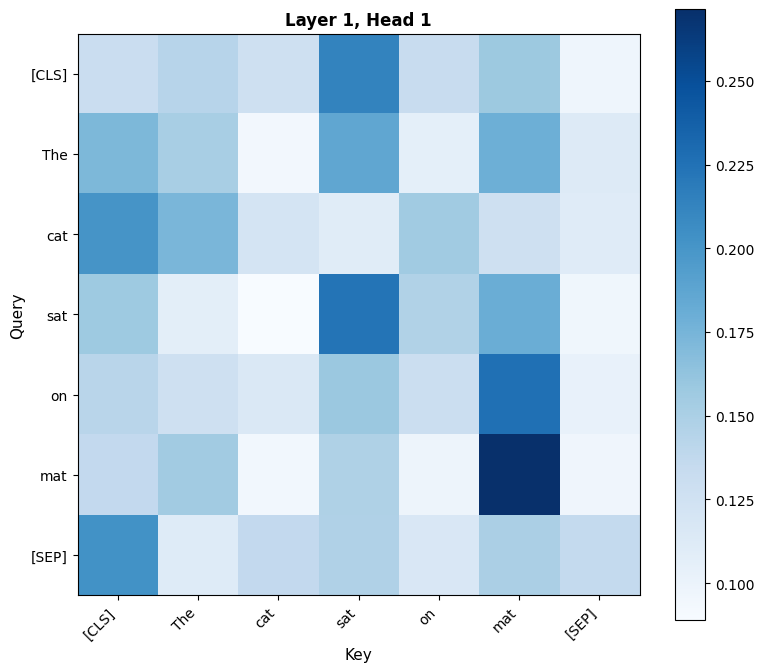

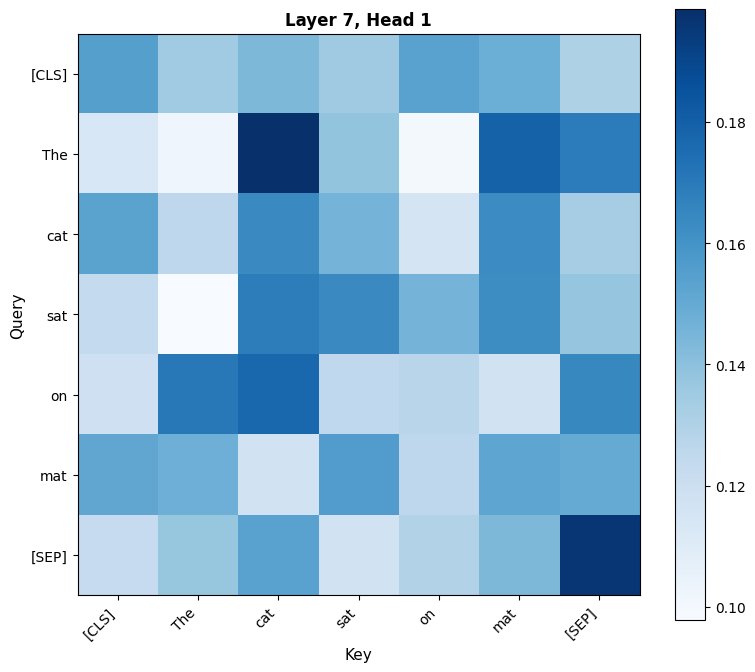

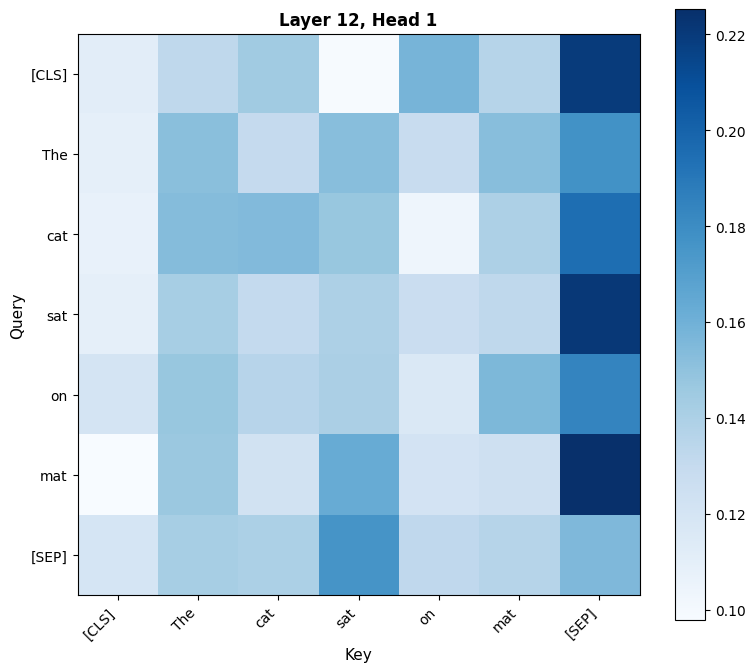

In [11]:
def visualize_attention(attention_weights, tokens, layer=0, head=0):
    """Visualize attention weights."""
    attn = attention_weights[layer][0, head].detach().numpy()
    
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(attn, cmap='Blues')
    
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(tokens, fontsize=10)
    ax.set_xlabel('Key', fontsize=11)
    ax.set_ylabel('Query', fontsize=11)
    ax.set_title(f'Layer {layer+1}, Head {head+1}', fontsize=12, fontweight='bold')
    
    plt.colorbar(im, ax=ax, shrink=0.8)
    plt.tight_layout()
    plt.show()


# Visualize
bert_model = BertModel(BERT_BASE_CONFIG)
bert_model.eval()

tokens = ['[CLS]', 'The', 'cat', 'sat', 'on', 'mat', '[SEP]']
input_ids = torch.randint(100, 1000, (1, len(tokens)))

with torch.no_grad():
    outputs = bert_model(input_ids, output_attentions=True)

print("Attention visualization across layers:")
for layer_idx in [0, 6, 11]:
    visualize_attention(outputs['attentions'], tokens, layer=layer_idx, head=0)

---

## Part 11: Fine-tuning Demo

In [12]:
class DemoDataset(Dataset):
    """Simple dataset for demonstration."""
    def __init__(self, num_samples, seq_len, vocab_size, num_labels):
        self.input_ids = torch.randint(0, vocab_size, (num_samples, seq_len))
        self.attention_mask = torch.ones(num_samples, seq_len)
        self.labels = torch.randint(0, num_labels, (num_samples,))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


# Use smaller config for demo
demo_config = BertConfig(
    vocab_size=1000,
    hidden_size=128,
    num_hidden_layers=2,
    num_attention_heads=2,
    intermediate_size=256,
    max_position_embeddings=64
)

model = BertForSequenceClassification(demo_config, num_labels=2)
model.to(device)

train_data = DemoDataset(200, 32, 1000, 2)
val_data = DemoDataset(50, 32, 1000, 2)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

print(f"Model parameters: {count_parameters(model):,}")
print(f"Training samples: {len(train_data)}")
print()

# Training loop
for epoch in range(3):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Evaluate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs['logits'].argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    acc = correct / total
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Val Acc = {acc:.4f}")

print("\nTraining complete!")

Model parameters: 418,434
Training samples: 200

Epoch 1: Loss = 0.6938, Val Acc = 0.5400
Epoch 2: Loss = 0.6930, Val Acc = 0.5400
Epoch 3: Loss = 0.6930, Val Acc = 0.5600

Training complete!


---

## Summary

We implemented BERT from scratch:

| Component | Description |
|-----------|------------|
| `BertConfig` | Model configuration |
| `BertEmbeddings` | Token + Position + Segment embeddings |
| `BertSelfAttention` | Multi-head self-attention |
| `BertIntermediate` + `BertOutput` | Feed-forward network |
| `BertLayer` | Single encoder layer |
| `BertEncoder` | Stack of layers |
| `BertPooler` | [CLS] pooling |
| `BertModel` | Complete encoder |
| Task heads | Classification, NER, QA |

### Key Details
- GELU activation
- Learned position embeddings
- Weight init: std=0.02
- Attention mask: additive (-10000)

---

**Paper:** [BERT: Pre-training of Deep Bidirectional Transformers](https://arxiv.org/abs/1810.04805)

**So yes, this was the complete explanation of the research paper, covering the key concepts and important implementation details. You can explore more related content on my profile—make sure to follow and upvote for more such insights.**